In [2]:
import os
import re
import sys

# web scraping
import requests
from bs4 import BeautifulSoup
from contextlib import suppress
from requests_toolbelt import sessions
from itertools import chain
from multiprocessing.dummy import Pool

# data
import itertools
import janitor
import numpy as np
import pandas as pd
from scipy import stats

# model fit
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# model eval
from sklearn.metrics import make_scorer
from sklearn.metrics import ndcg_score

# plotting
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# misc
from tqdm.notebook import tqdm
from IPython.display import clear_output

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

In [5]:
# data path info
DATA_DIR    = "./data"
DRAFT_PKL   = os.path.join(DATA_DIR, "draft.pkl")
METRICS_PKL = os.path.join(DATA_DIR, "metrics.pkl")
COLLEGE_PKL = os.path.join(DATA_DIR, "college.pkl")

In [6]:
# url info
NBA_BASE  = "https://basketball-reference.com/"
CBB_BASE  = "https://sports-reference.com/cbb/"
DRAFT_URL = lambda y: f"/draft/NBA_{y}.html"

In [7]:
# open sessions with relevant sites
NBA_HTTP = sessions.BaseUrlSession(base_url=NBA_BASE)

In [8]:
def get_url_soup(url):
    """
    Get bs4 object from url.
    """
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text)
    return soup

In [9]:
def get_session_soup(http, path):
    """
    Get soup of path within session.
    """
    resp = http.get(path)
    soup = BeautifulSoup(resp.text)
    return soup

In [10]:
def link_from_re(soup, key):
    """
    Get link from <a> that has specified text.
    Returns empty string if not found.
    """
    link = ''
    with suppress(TypeError):
        link = soup.find('a', text=re.compile(key))['href']
    return link

## Create index table with draft info

In [11]:
def get_draft_info(year):
    """
    Wrapper for draft info retrieval.
    To be used with multithreading.
    """
    # find draft info table
    soup  = get_session_soup(NBA_HTTP, DRAFT_URL(year))
    table = soup.find('table').find('tbody')
    
    # decompose headers
    for thead in table.find_all('tr', {'class':'thead'}):
        thead.decompose()
    
    rows = []
    
    # for each player row...
    for row in tqdm(table.find_all('tr'), 
                    leave=False, desc=str(year)):
        # get player name, id
        plyr = row.find('td', {'data-stat':'player'})
        if not plyr:
            continue
        href = plyr.find('a')['href']
        pid  = re.split(r'\.|\/', href)[3]
        name = plyr.get_text()
        
        # get draft position
        pick = int(
            row
            .find('td', {'data-stat':'pick_overall'})
            .find('a')
            .get_text()
        )
        
        # find college
        college = (
            row
            .find('td', {'data-stat':'college_name'})
            ['csk']
        )
        
        # find seasons
        seasons = (
            row
            .find('td', {'data-stat':'seasons'})
            .get_text()
        )

        if college != 'Zzz' and seasons:
            # get college link
            plyr_soup = get_session_soup(NBA_HTTP, href)
            cbb_link  = link_from_re(plyr_soup, "College Basketball at")
            if not cbb_link:
                continue

            # collect row data
            rows.append([pid, name, href, cbb_link, year, pick])
        else:
            continue
            
    return rows

In [12]:
year_lwr = 1998
year_upr = 2021

cols = ['pid', 'name', 'nba_link', 'cbb_link', 'draft_year', 'pick']

if not os.path.exists(DRAFT_PKL):
    # retrieve draft info via multithreading
    years = range(year_lwr, year_upr)
    pool  = Pool(len(years))
    rows  = pool.map(get_draft_info, years)
    
    # assemble draft df
    draft_df = (
        pd
        .DataFrame(chain(*rows),
                   columns=cols
                  )
        .set_index('pid')
        .sort_values(by=['draft_year', 'pick'])
    )
    draft_df.to_pickle(DRAFT_PKL)
else:
    draft_df = pd.read_pickle(DRAFT_PKL)

In [13]:
draft_df

,name,nba_link,cbb_link,draft_year,pick
pid,,,,,
olowomi01,Michael Olowokandi,/players/o/olowomi01.html,https://www.sports-reference.com/cbb/players/m...,1998,1
bibbymi01,Mike Bibby,/players/b/bibbymi01.html,https://www.sports-reference.com/cbb/players/m...,1998,2
lafrera01,Raef LaFrentz,/players/l/lafrera01.html,https://www.sports-reference.com/cbb/players/r...,1998,3
jamisan01,Antawn Jamison,/players/j/jamisan01.html,https://www.sports-reference.com/cbb/players/a...,1998,4
cartevi01,Vince Carter,/players/c/cartevi01.html,https://www.sports-reference.com/cbb/players/v...,1998,5
...,...,...,...,...,...
rillegr01,Grant Riller,/players/r/rillegr01.html,https://www.sports-reference.com/cbb/players/g...,2020,56
perryre01,Reggie Perry,/players/p/perryre01.html,https://www.sports-reference.com/cbb/players/r...,2020,57
reedpa01,Paul Reed,/players/r/reedpa01.html,https://www.sports-reference.com/cbb/players/p...,2020,58


## Get college stats for players in index

In [14]:
def height_to_inches(ht):
    """
    Convert string height 'ft-in' to inches.
    """
    vals = [int(n) for n in ht.split('-')]
    inch = vals[0] * 12 + vals[1]
    return inch

In [15]:
def gather_college_stats(url, ids):
    """
    Extract college stats from given player page.
    """
    soup    = get_url_soup(url)
    df_list = []
    
    # get list of table soups
    tables = soup.find_all('table', {'id':ids})
    
    # remove footers & empty rows, collect df
    for t in tables:
        t.find('tfoot').decompose()
        for row in t.find('tbody').find_all('tr', {'id':None}):
            row.decompose()
        df_list.append(
            pd.read_html(str(t))[0]
        )
        
    # height
    hgt = soup.find('span', {'itemprop':'height'}).get_text()
    hgt = height_to_inches(hgt)
    
    # weight
    try:
        wgt = soup.find('span', {'itemprop':'weight'})
        wgt = int(wgt.get_text()[:-2])
    except:
        wgt = 205
    
    # position
    try:
        pos = soup.find('strong', text=re.compile("Position:"))
        pos = pos.parent.get_text().split(':')[1].strip()
    except:
        pos = 'Forward'
    
    # count "bling"
    bling = soup.find('ul', {'id':'bling'})
    bling = sum([1 for _ in bling.find_all('li')]) if bling else 0
    
    # get RSCI
    try:
        rsci = soup.find('strong', text=re.compile("RSCI"))
        rsci = int(rsci.parent.get_text().split(' ')[3])
    except:
        rsci = 101
    
    # compose full df
    df = (
        pd
        .concat(df_list, join='inner', axis=1)
        .clean_names()
        .dropna(axis=1)
        .assign(height=hgt,
                weight=wgt,
                position=pos,
                bling=bling,
                rsci=rsci
               )
    )
    
    # remove duplicate columns
    df = df.loc[:, ~df.columns.duplicated()]
    return df

In [16]:
cbb_list  = []
table_ids = ['players_per_game', 'players_advanced']

if not os.path.exists(COLLEGE_PKL):
    # obtain cbb stats for each player/season
    for pid, row in tqdm(draft_df.iterrows(), 
                         total=len(draft_df)):
        stat_df = (
            gather_college_stats(row.cbb_link, table_ids)
            .assign(pid=pid)
            .set_index(['pid', 'season'])
        )
        cbb_list.append(stat_df)
        
    # save to pickle
    cbb_stats = pd.concat(cbb_list)
    cbb_stats.to_pickle(COLLEGE_PKL)
else:
    cbb_stats = pd.read_pickle(COLLEGE_PKL)

In [17]:
cbb_stats

school      conf   g    mp   fg   fga    fg%   2p  \
pid       season                                                           
olowomi01 1995-96     Pacific  Big West  25  10.3  1.6   3.0  0.526  1.6   
          1996-97     Pacific  Big West  19  22.8  4.9   8.7  0.570  4.9   
          1997-98     Pacific  Big West  33  31.7  9.4  15.4  0.609  9.4   
bibbymi01 1996-97     Arizona    Pac-10  34  32.6  4.4  10.0  0.445  2.5   
          1997-98     Arizona    Pac-10  35  32.0  6.0  12.9  0.464  3.8   
...                       ...       ...  ..   ...  ...   ...    ...  ...   
harrija01 2019-20      Nevada       MWC  30  33.0  7.5  16.7  0.446  5.2   
merrisa01 2016-17  Utah State       MWC  30  26.7  3.3   7.4  0.450  1.8   
          2017-18  Utah State       MWC  34  35.4  5.6  11.2  0.504  2.8   
          2018-19  Utah State       MWC  35  35.3  6.5  14.1  0.461  4.1   
          2019-20  Utah State       MWC  32  35.0  6.1  13.2  0.461  3.3   

                    2pa    2p%  ...  blk%  usg%  pprod  orb%  drb%  stl%  \
pid       season                ...                                        
olowomi01 1995-96   3.0  0.526  ...   NaN   NaN    NaN   NaN   NaN   NaN   
          1996-97   8.7  0.570  ...   NaN   NaN    NaN   NaN   NaN   NaN   
          1997-98  15.4  0.609  ...   NaN   NaN    NaN   NaN   NaN   NaN   
bibbymi01 1996-97   5.0  0.497  ...   NaN   NaN    NaN   NaN   NaN   NaN   
          1997-98   7.2  0.526  ...   NaN   NaN    NaN   NaN   NaN   NaN   
...                 ...    ...  ...   ...   ...    ...   ...   ...   ...   
harrija01 2019-20  10.6  0.495  ...   0.5  32.7  627.0   2.8  17.6   1.9   
merrisa01 2016-17   4.0  0.450  ...   0.7  17.5  291.0   1.8  11.0   2.1   
          2017-18   5.0  0.553  ...   0.7  20.8  507.0   0.7  10.4   1.7   
          2018-19   7.6  0.534  ...   0.9  26.5  683.0   1.2  10.9   1.7   
          2019-20   6.4  0.515  ...   0.3  24.9  575.0   0.7  11.8   1.5   

                    per  obpm  dbpm  bpm  
pid       season                          
olowomi01 1995-96   NaN   NaN   NaN  NaN  
          1996-97   NaN   NaN   NaN  NaN  
          1997-98   NaN   NaN   NaN  NaN  
bibbymi01 1996-97   NaN   NaN   NaN  NaN  
          1997-98   NaN   NaN   NaN  NaN  
...                 ...   ...   ...  ...  
harrija01 2019-20  26.4   6.7   0.9  7.6  
merrisa01 2016-17  16.9   2.3   1.7  4.0  
          2017-18  19.9   4.8   0.8  5.5  
          2018-19  24.8   6.1   1.5  7.6  
          2019-20  25.0   7.6   2.4  9.9  

[2656 rows x 53 columns]

## Get NBA target metrics

In [18]:
def gather_metrics(pid, table, stats):
    """
    Gather metrics for given advanced NBA stat table.
    """
    # remove summary footer
    table.find('tfoot').decompose()
    
    # return df of relevant stats
    return (
        pd.read_html(str(table))[0]
          .clean_names()
          .assign(pid=pid)
          .drop_duplicates(['season'], keep='first')
          .set_index(['pid', 'season'])
          .loc[:, stats]
    )

In [19]:
stat_list = ['ws', 'vorp', 'bpm']
metrics   = []

if not os.path.exists(METRICS_PKL):
    # obtain stats for each player/season
    for pid, row in tqdm(draft_df.iterrows(), 
                         total=len(draft_df)):
        soup  = get_session_soup(NBA_HTTP, row.nba_link)
        table = soup.find('table', {'id':'advanced'})
        metrics.append(gather_metrics(pid, table, stats))
        
    # save to pickle
    nba_metrics = pd.concat(metrics)
    nba_metrics.to_pickle(METRICS_PKL)
else:
    nba_metrics = pd.read_pickle(METRICS_PKL)

In [20]:
nba_metrics.loc['duranke01']

,ws,vorp,bpm
season,,,
2007-08,2.3,1.3,-0.1
2008-09,7.9,3.8,3.3
2009-10,16.1,7.5,7.1
2010-11,12.0,5.3,4.9
2011-12,12.2,5.8,7.0
2012-13,18.9,8.9,9.3
2013-14,19.2,9.6,10.2
2014-15,4.8,2.8,10.0
2015-16,14.5,7.8,9.9


## Construct "relevancy scores"

In [21]:
def quant_rel_score(arr, x, q=10, kind='rank'):
    """
    Calculate relevancy score as:
        rel_score = 10s place of percentile of mean of 3 highest metric values / 10
    """
    percentile = stats.percentileofscore(arr, x, kind=kind)
    rel_scores = np.round(percentile / q)
    return int(rel_scores)

In [22]:
def sigmoid_rel_score(arr):
    """
    Calculate relevancy score as:
        rel_score = round(10*sigmoid(x-1))
    to keep rarity of high metrics while clamping lower metrics
    """
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    rel_scores = np.round(10*sigmoid(arr-1))
    return rel_scores

In [23]:
metric = 'vorp'

targets = (
    nba_metrics
    .groupby('pid')[metric]
    .apply(lambda x: x.nlargest(3).mean())
#     .apply(lambda x: x.head(1).mean())
    .to_frame()
#     .assign(rel_score=lambda x: x[metric])
#     .assign(rel_score=lambda x: sigmoid_rel_score(x[metric]))
    .assign(rel_score=lambda x: x[metric].apply(
        lambda y: quant_rel_score(x[metric], y, q=10)
    ))
)


targets.sort_values(by=['vorp'], ascending=False)

,vorp,rel_score
pid,,
paulch01,8.800000,10
duranke01,8.766667,10
hardeja01,8.466667,10
wadedw01,8.200000,10
curryst01,8.033333,10
...,...,...
okorois01,-0.800000,0
chrisse01,-0.800000,0
morriad01,-0.833333,0


## Develop features for training

In [24]:
top_5_conf   = ["SEC", "ACC", "Big-12", "Big-10", "Pac-12"]
top_5_school = ["Kentucky", "Duke", "North Carolina", "UCLA", "Kansas"]
drop_columns = ['school', 'conf', 'fg', '2p', '3p', 'ws_40']

# assemble feature df
features = (
    cbb_stats
    .fillna({'3p%':0})
    .dropna(subset=['ws'])
    .dropna(axis=1)
    
    # create year column to track college experience
    .assign(years=cbb_stats.groupby('pid').cumcount()+1)
    
    # big 5 conference flag
    .assign(top_conf=lambda x: x.conf.isin(top_5_conf))
    
    # big 5 school flag (most picks over time)
    .assign(top_school=lambda x: x.school.isin(top_5_school))
    
    # RSCI top 10? 50?
    .assign(rsci_10=cbb_stats.rsci <= 10)
    .assign(rsci_50=cbb_stats.rsci <= 50)
    .assign(rsci_100=cbb_stats.rsci <= 100)
    
    # take year with best ws/40
    .reset_index()
    .sort_values('ws_40', ascending=False)
    .drop_duplicates(subset=['pid'])
    .set_index('pid')
    
    # attach relevancy scores and draft year
    .join(draft_df.loc[:, ['draft_year', 'pick']], 
          how='inner')
    .join(targets.loc[:, 'rel_score'],
          how='inner')
    
    # remove unnecessary cols
    .drop(drop_columns, axis=1)
)

# one-hot position
features = (
    features
    .join(pd.get_dummies(features.position), 
          how='inner')
    .clean_names()
    .query("draft_year <= 2018")
)

## Split data and fit model

In [25]:
def x_y_split(df, exclude, response):
    """
    Get X, y from given df exluding columns.
    """
    X, y = (
        df.loc[:, ~df.columns.isin(exclude)],
        df.loc[:,  df.columns.isin(response)]
    )
    return X, y

In [ ]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh', figsize = (20,10))

## Hyperparameter tuning

In [26]:
def x_y_split(df, exclude, response):
    """
    Get X, y from given df exluding columns.
    """
    X, y = (
        df.loc[:, ~df.columns.isin(exclude)],
        df.loc[:,  df.columns.isin(response)]
    )
    return X, y

In [27]:
def standardize(x):
    """
    Subtract mean and divide by std.
    """
    num = x - np.mean(x)
    den = np.std(x)
    return num / den

In [28]:
# set aside validation for comparison to real draft
test_years  = [2001, 2004, 2007, 2010, 2013, 2018]
train_years = list(
    set(np.unique(features.draft_year)) - set(test_years)
)

# split data
train_set = (
    features
    .query(f"draft_year not in {test_years}")
    .sort_values(by='draft_year')
)
test_set = (
    features
    .query(f"draft_year in {test_years}")
    .sort_values(by='draft_year')
)

In [29]:
# useful column sets
exclude_cols = ['season', 'position', 'pick', 'rel_score', 'draft_year', 'rsci']
response_col = ['rel_score']

# define param grid
param_grid = {
    'objective':        ['rank:ndcg'],
    'min_child_weight': [1, 5, 10],
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth':        [3, 6, 9],
    'n_estimators':     [100, 300, 500]
}
keys = param_grid.keys()

comb = list(itertools.product(*param_grid.values()))

best_params = {}
best_ndcg   = 0

# manual grid search because I can't figure
# out GridSearchCV for ranking
for vals in tqdm(comb):
    # params instance
    params = dict(zip(keys, vals))
        
    # LOOCV
    for year in train_years:
        # split into train, test
        train_data = (
            train_set
            .query(f"draft_year!={year}")
            .sort_values(by="draft_year")
        )
        test_data = (
            train_set
            .query(f"draft_year=={year}")
            .sort_values(by="draft_year")
        )

        # get X, y splits
        X_train, y_train = x_y_split(train_data, 
                                     exclude_cols, 
                                     response_col)
        X_test,  y_test  = x_y_split(test_data,  
                                     exclude_cols, 
                                     response_col)

        # train model
        ranker = xgb.XGBRanker(**params).fit(
            X_train, y_train, 
            qid=train_data.draft_year
        )

        # evaluate on one-out
        y_pred  = ranker.predict(X_test)
        eval_df = (
            y_test
            .join(draft_df.loc[:, 'pick'], how='inner')
            .assign(pred=y_pred,
                    pick_score=lambda x: 1/x.pick)
            .sort_values(by='pred', ascending=False)
        )

        # ndcg scores
        model_ndcg = ndcg_score([eval_df.rel_score],
                                [eval_df.pred], k=20
                               )
        
        # save best result
        if model_ndcg > best_ndcg:
            best_ndcg   = model_ndcg
            best_params = params

  0%|          | 0/243 [00:00<?, ?it/s]

In [30]:
ndcg_dict = {}
eval_list = []

# LOOCV
for year in test_years:
    # split into train, test
    train_data = (
        features
        .query(f"draft_year not in {test_years}")
        .sort_values(by="draft_year")
    )
    test_data = (
        features
        .query(f"draft_year=={year}")
        .sort_values(by="draft_year")
    )
        
    # get X, y
    X_train, y_train = x_y_split(train_data, 
                                 exclude_cols, 
                                 response_col)
    X_test,  y_test  = x_y_split(test_data,  
                                 exclude_cols, 
                                 response_col)
    
    # train model
    ranker = xgb.XGBRanker(**best_params).fit(
        X_train, y_train, 
        qid=train_data.draft_year
    )
    
    # evaluate on one-out
    y_pred  = ranker.predict(X_test)
    eval_df = (
        y_test
        .join(draft_df.loc[:, 'pick'], how='inner')
        .assign(pred_score=y_pred,
                pick_score=lambda x: np.log(1/x.pick),
                draft_year=year
               )
        .sort_values(by='pred_score', ascending=False)
    )
    eval_list.append(eval_df)
    
    # ndcg scores
    model_ndcg = ndcg_score([eval_df.rel_score],
                            [eval_df.pred_score], k=20
                           )
    pick_ndcg  = ndcg_score([eval_df.rel_score],
                            [eval_df.pick_score], k=20
                           )
    rand_ndcg  = np.mean(list(map(
        lambda x: ndcg_score([eval_df.rel_score],
                             [np.random.rand(x)],
                             k=20
                           ),
        np.ones(50, dtype=int)*len(y_pred)
    )))
        
    ndcg_dict[year] = [model_ndcg, pick_ndcg, rand_ndcg]
    
ndcg_df = (
    pd
    .DataFrame(ndcg_dict).T
    .reset_index()
    .rename({'index':'season', 
             0:'model', 1:'pick', 2:'random'}, axis='columns')
    .melt(id_vars=['season'], 
          value_vars=['random', 'model', 'pick'],
          var_name='source', value_name='ndcg'
         )
)

# collect predicted scores
eval_df = pd.concat(eval_list)

# standardize scores for boxplot
eval_df.pred_score = standardize(eval_df.pred_score)
eval_df.pick_score = standardize(eval_df.pick_score)

# pivot longer
eval_df = (
    eval_df
    .reset_index()
    .melt(id_vars=['pid', 'rel_score'],
          value_vars=['pred_score', 'pick_score'],
          var_name='source', value_name='value'
         )
)

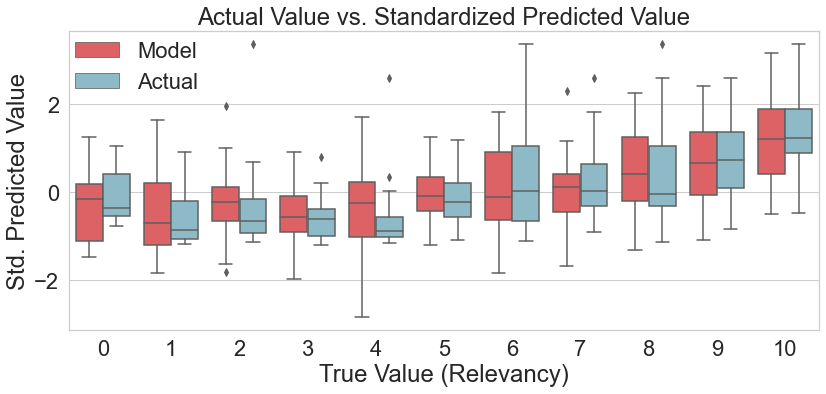

In [87]:
colors = ['#F04E52', '#85BFD0', '#CBE94C']

sns.set(rc={'figure.figsize':(12,6)})
sns.set_theme(style="whitegrid", 
              font_scale=2)
sns.set_palette(colors)

# predicted value boxplot
ax = sns.boxplot(x='rel_score', 
                 y='value',
                 hue='source',
                 data=eval_df
                )

#
# clean up axes
plt.xlabel("True Value (Relevancy)")
plt.ylabel("Std. Predicted Value")
plt.title("Actual Value vs. Standardized Predicted Value")
# plt.xticks(rotation=45)

# fix legend
legend = plt.gca().legend(loc='upper left',
                          bbox_to_anchor=(-0.0175,1.03),
                          facecolor='#E9F2F9',
                          framealpha=0
                         )
legend.get_texts()[0].set_text('Model')
legend.get_texts()[1].set_text('Actual')

plt.tight_layout()
plt.savefig('./images/results_3.png', transparent=True)
plt.show()

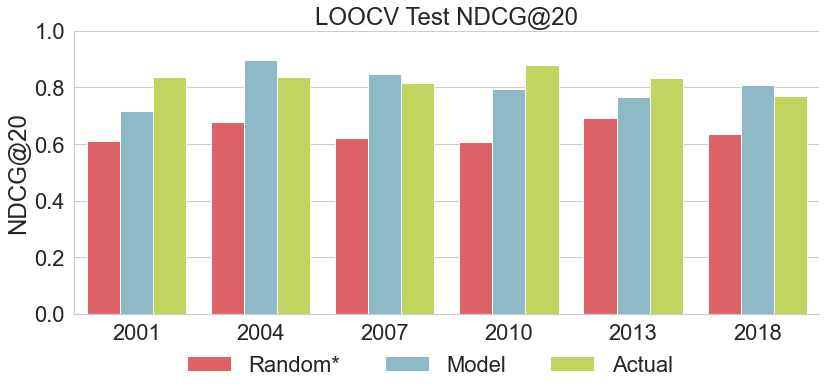

In [88]:
sns.set_theme(style="whitegrid", 
              font_scale=2)
sns.set_palette(colors)

# grouped bar plot
ax = sns.catplot(
    data=ndcg_df, kind='bar',
    x='season', y='ndcg', hue='source',
    height=6, aspect=2,
    legend=False
)

# clean up axes
plt.ylim([0, 1])
plt.xlabel("")
plt.ylabel("NDCG@20")
plt.title("LOOCV Test NDCG@20")
# plt.xticks(rotation=45)

# edit legend
legend = plt.gca().legend(loc='upper left',
                          bbox_to_anchor=(0.125,-0.075),
                          fancybox=True, ncol=3,
                          framealpha=0,
                          facecolor='#E9F2F9'
                         )
legend.get_texts()[0].set_text('Random*')
legend.get_texts()[1].set_text('Model')
legend.get_texts()[2].set_text('Actual')

plt.tight_layout()
plt.savefig('./images/results_4.png', transparent=True)
plt.show()